## Decision Tree

### Preparing the data

In [1]:
# Import the librairies
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from mlxtend.plotting import plot_decision_regions
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
import matplotlib.pyplot as plt

import seaborn as sns

# Import the dataset
data = 'flight_data_2024_sample.csv'
flight_df = pd.read_csv(data)
print(flight_df.head())

# Remove non-important independent variables
print(flight_df.columns)
flight_df.drop(['taxi_out', 'wheels_off',
       'wheels_on', 'taxi_in', 'crs_arr_time', 'arr_time', 'arr_delay',
    'cancellation_code', 'diverted', 'crs_elapsed_time',
       'actual_elapsed_time', 'air_time', 'carrier_delay',
       'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay'], axis=1, inplace=True)
print(flight_df.columns)

# Drop cancelled flights
flight_df = flight_df[flight_df['cancelled'] == 0]

# Create flight delay dummy variable
flight_df['flight_delayed'] = (flight_df['dep_delay'] > 0).astype(int)

# Train-validation-test split
train_df, temp_df = train_test_split(
    flight_df, test_size=0.40, random_state=42)

validation_df, test_df = train_test_split(
    temp_df, test_size=0.50, random_state=42)
print(train_df.shape, validation_df.shape, test_df.shape)

# Define features/target per split
X_train = train_df.drop("flight_delayed", axis=1)
y_train = train_df["flight_delayed"]

X_validation = validation_df.drop("flight_delayed", axis=1)
y_validation = validation_df["flight_delayed"]

X_test = test_df.drop("flight_delayed", axis=1)
y_test = test_df["flight_delayed"]

# Encode the categorical columns to keep
from sklearn.preprocessing import LabelEncoder

categorical_cols = ['op_unique_carrier', 'origin', 'dest']

for col in categorical_cols:
    # Fit on all data combined
    all_values = pd.concat([X_train[col], X_validation[col], X_test[col]]).astype(str)
    le = LabelEncoder()
    le.fit(all_values)
    
    # Transform each set
    X_train[col] = le.transform(X_train[col].astype(str))
    X_validation[col] = le.transform(X_validation[col].astype(str))
    X_test[col] = le.transform(X_test[col].astype(str))

# Drop object columns and fl_date
columns_to_drop = ['fl_date', 'origin_city_name', 'origin_state_nm', 'dest_city_name', 'dest_state_nm','dep_delay','crs_dep_time','op_carrier_fl_num']
X_train = X_train.drop(columns_to_drop, axis=1)
X_validation = X_validation.drop(columns_to_drop, axis=1)
X_test = X_test.drop(columns_to_drop, axis=1)

   year  month  day_of_month  day_of_week     fl_date op_unique_carrier  \
0  2024      4            18            4  2024-04-18                MQ   
1  2024      1             1            1  2024-01-01                AA   
2  2024     12            12            4  2024-12-12                9E   
3  2024      4             8            1  2024-04-08                WN   
4  2024      2            16            5  2024-02-16                WN   

   op_carrier_fl_num origin       origin_city_name origin_state_nm  ...  \
0             3535.0    DFW  Dallas/Fort Worth, TX           Texas  ...   
1              148.0    CLT          Charlotte, NC  North Carolina  ...   
2             5440.0    CHA        Chattanooga, TN       Tennessee  ...   
3             1971.0    OMA              Omaha, NE        Nebraska  ...   
4              862.0    BWI          Baltimore, MD        Maryland  ...   

  diverted crs_elapsed_time actual_elapsed_time  air_time  distance  \
0        0            151.0

### Training the model

#### Cross validation

In [2]:
# Import a Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier
# Import the GridSearchCV class
from sklearn.model_selection import GridSearchCV
# Import the random module
import random

# Create a Decision Tree Classifier
dt = DecisionTreeClassifier(random_state=42)
# Define the hyperparameters to tune
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': np.arange(3,10,1),
    'min_samples_leaf': [5, 8, 10],
    'min_samples_split': [5, 10, 25]
}

# Create a GridSearchCV object
gs = GridSearchCV(estimator=dt,
                  param_grid=param_grid, 
                  cv=5, 
                  return_train_score=True,
                  scoring= 'roc_auc',
                  n_jobs=-1, verbose=0)

# Fit the GridSearchCV object on the training data
random.seed(42)
gs.fit(X_train, y_train)
m_cart = gs.best_estimator_
# Display the best hyperparameters
print("Best hyperparameters:", gs.best_params_)

Best hyperparameters: {'criterion': 'gini', 'max_depth': np.int64(5), 'min_samples_leaf': 5, 'min_samples_split': 25}


#### Plotting the decision tree

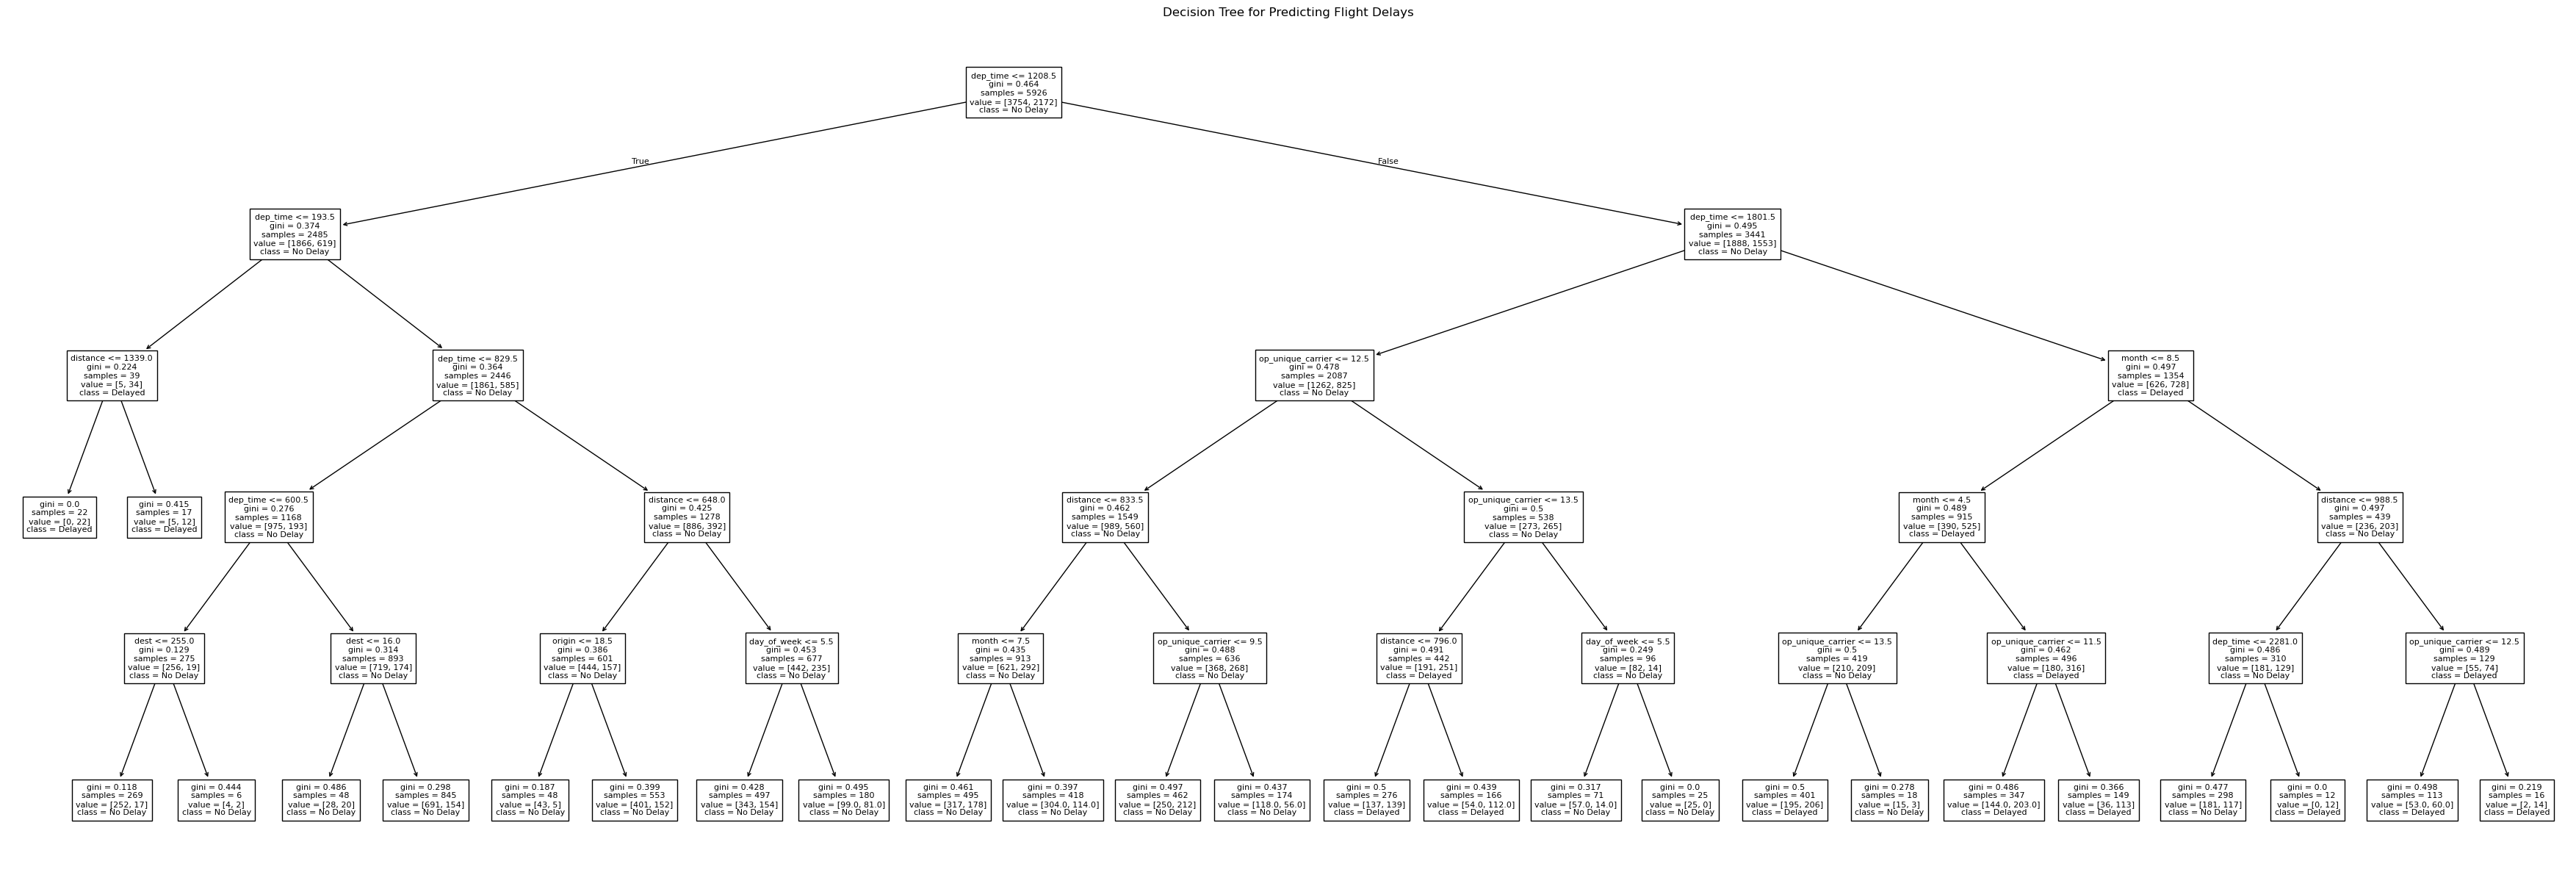

In [3]:
from sklearn.tree import plot_tree

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(45, 15), dpi=100)

plot_tree(
    m_cart,                           
    feature_names=X_train.columns,
    class_names=['No Delay', 'Delayed'],
    filled=False,
    fontsize=8
)
plt.title("Decision Tree for Predicting Flight Delays")
plt.savefig("decision_tree_flight_delay.png", bbox_inches='tight', dpi=100)
plt.show()

### Evaluating the model

#### ROC AUC

Training ROC AUC score: 0.7027973721829925
Testing ROC AUC score: 0.6664844731881022


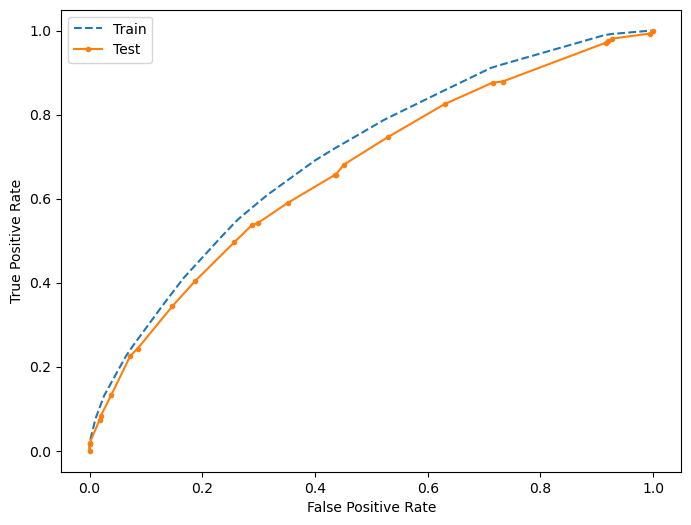

In [4]:
train_pred = m_cart.predict_proba(X_train)[:,1]
test_pred = m_cart.predict_proba(X_test)[:,1]

from sklearn.metrics import roc_auc_score, roc_curve
# Calculate the ROC AUC score for the training and testing sets
train_auc = roc_auc_score(y_train, train_pred)
test_auc = roc_auc_score(y_test, test_pred)
print("Training ROC AUC score:", train_auc)
print("Testing ROC AUC score:", test_auc)
# Plot the ROC curve for the training and testing sets
fpr_train, tpr_train, _ = roc_curve(y_train, train_pred)
fpr_test, tpr_test, _ = roc_curve(y_test, test_pred)

plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, linestyle='--', label='Train')
plt.plot(fpr_test, tpr_test, marker='.', label='Test')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

#### Training and testing accuracy

In [5]:
from sklearn.metrics import confusion_matrix, accuracy_score
t = 0.5
print("Train Accuracy: %.3f" %  accuracy_score(y_train, train_pred > t))
print("Test Accuracy: %.3f" %  accuracy_score(y_test, test_pred > t))

# If we wanted to get all of the elements of the confusion matrix, we could pull them like this:
tn, fp, fn, tp = confusion_matrix(y_train, train_pred > t).ravel()

Train Accuracy: 0.679
Test Accuracy: 0.659


#### Classification Evaluation Function

In [6]:
# Defining a classification_evaluation function(model, X_train, y_train, X_test, y_test, threshold=0.5):
def classification_evaluation(model, X_train, y_train, X_test, y_test, threshold=0.5):
    from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, f1_score

    train_pred = model.predict_proba(X_train)[:, 1]
    test_pred = model.predict_proba(X_test)[:, 1]
    
    train_auc = roc_auc_score(y_train, train_pred)
    test_auc = roc_auc_score(y_test, test_pred)
    
    fpr_train, tpr_train, _ = roc_curve(y_train, train_pred)
    fpr_test, tpr_test, _ = roc_curve(y_test, test_pred)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr_train, tpr_train, linestyle='--', label='Train')
    plt.plot(fpr_test, tpr_test, marker='.', label='Test')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

    print("Training ROC AUC score:", train_auc)
    print("Testing ROC AUC score:", test_auc)
    print("Train Accuracy: %.3f" % accuracy_score(y_train, train_pred > threshold))
    print("Test Accuracy: %.3f" % accuracy_score(y_test, test_pred > threshold))
    # report precision, recall and f1 score for the training and testing sets
    print("Train Precision: %.3f" % precision_score(y_train, train_pred > threshold))   
    print("Test Precision: %.3f" % precision_score(y_test, test_pred > threshold))
    print("Train Recall: %.3f" % recall_score(y_train, train_pred > threshold)) 
    print("Test Recall: %.3f" % recall_score(y_test, test_pred > threshold))
    print("Train F1 Score: %.3f" % f1_score(y_train, train_pred > threshold))
    print("Test F1 Score: %.3f" % f1_score(y_test, test_pred > threshold))

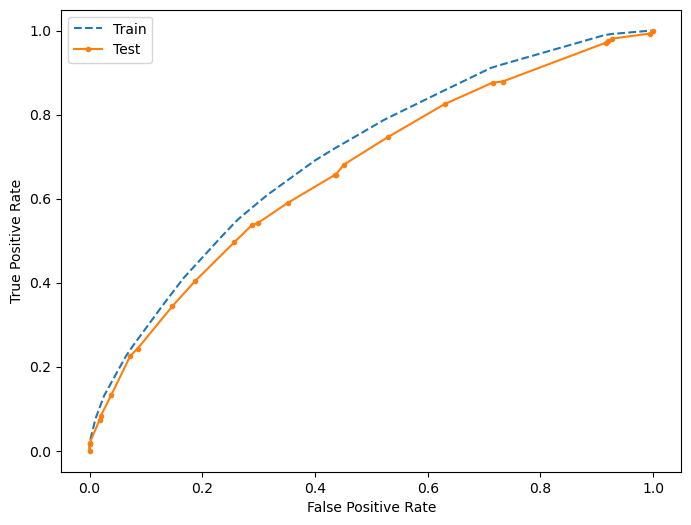

Training ROC AUC score: 0.7027973721829925
Testing ROC AUC score: 0.6664844731881022
Train Accuracy: 0.679
Test Accuracy: 0.659
Train Precision: 0.588
Test Precision: 0.566
Train Recall: 0.411
Test Recall: 0.403
Train F1 Score: 0.484
Test F1 Score: 0.471


In [7]:
classification_evaluation(m_cart, X_train, y_train, X_test, y_test, threshold=0.5)

## Gradient Boosting Classifier

### Training the model

In [8]:
from sklearn.ensemble import GradientBoostingClassifier

# Create the Random Forest Classifier
gb = GradientBoostingClassifier(random_state=42)

# Define the hyperparameters to tune
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': np.arange(3, 10, 1),      
    'min_samples_leaf': [0.01, 0.02],
    'max_features': [0.3, 0.5, 0.8, 'sqrt', 'log2']
}

# Create the GridSearchCV object
grid_search = GridSearchCV(
    estimator = gb,
    param_grid = param_grid,
    cv = 5,
    scoring = 'accuracy',
    n_jobs = -1,
    verbose = 1,
    return_train_score = True
)

# Fit the grid search on the training data
random.seed(42)
grid_search.fit(X_train, y_train)

# Get the best model from the grid search
best_gb = grid_search.best_estimator_

# Display the best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)

Fitting 5 folds for each of 210 candidates, totalling 1050 fits
Best hyperparameters: {'max_depth': np.int64(5), 'max_features': 0.3, 'min_samples_leaf': 0.02, 'n_estimators': 100}


#### Feature Importances

/var/folders/ll/8f8k1sqx2j78xbkwtr1w8s2w0000gn/T/ipykernel_94439/4273581008.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importances_gb.head(10), palette='flare')


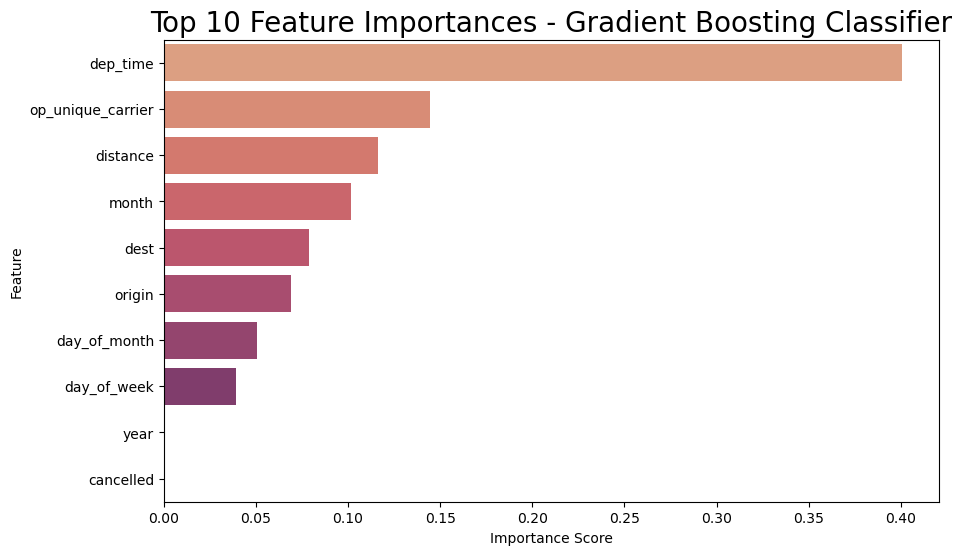

Top 3 Most Important Predictors:
             Feature  Importance
7           dep_time    0.400545
4  op_unique_carrier    0.144359
9           distance    0.116480


In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Get feature importances from the tuned Random Forest model
importances = best_gb.feature_importances_

# Create a DataFrame for visualization
feature_importances_gb = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances})

# Sort the DataFrame by importance
feature_importances_gb = feature_importances_gb.sort_values(by='Importance', ascending=False)

# Plot the top 10 features
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances_gb.head(10), palette='flare')
plt.title('Top 10 Feature Importances - Gradient Boosting Classifier', fontsize=20)
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

# Display the top 3 predictors
print("Top 3 Most Important Predictors:")
print(feature_importances_gb.head(3))

In [ ]:
#### Confusion Matrix

Test Accuracy: 0.6705


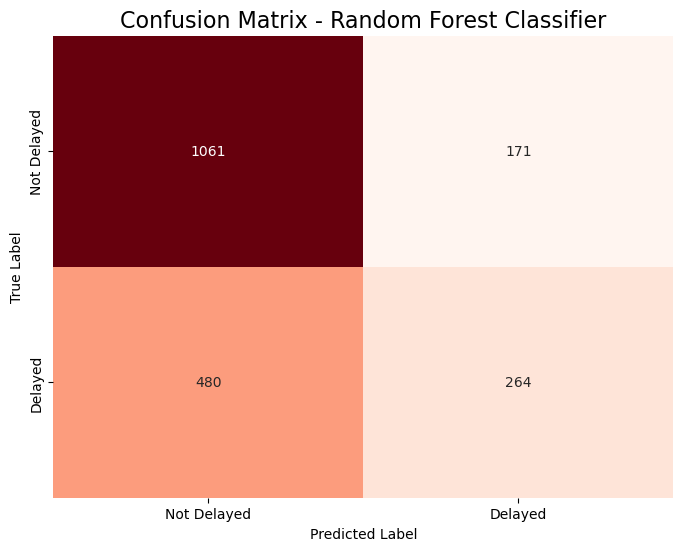


Classification Report:
              precision    recall  f1-score   support

 Not Delayed       0.69      0.86      0.77      1232
     Delayed       0.61      0.35      0.45       744

    accuracy                           0.67      1976
   macro avg       0.65      0.61      0.61      1976
weighted avg       0.66      0.67      0.65      1976



In [11]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Make predictions on test set
y_pred = best_gb.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', cbar=False,
            xticklabels=['Not Delayed', 'Delayed'],
            yticklabels=['Not Delayed', 'Delayed'])
plt.title('Confusion Matrix - Random Forest Classifier', fontsize=16)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Not Delayed', 'Delayed']))

#### Classification Evaluation Function

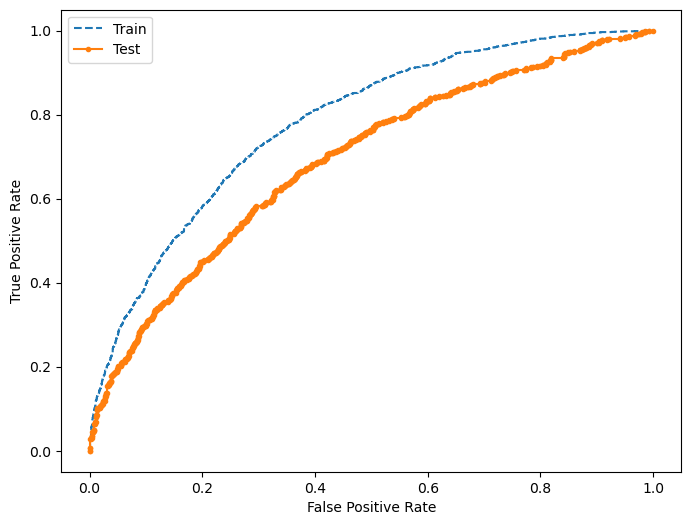

Training ROC AUC score: 0.7807336385694426
Testing ROC AUC score: 0.6910194979751432
Train Accuracy: 0.719
Test Accuracy: 0.671
Train Precision: 0.690
Test Precision: 0.607
Train Recall: 0.425
Test Recall: 0.355
Train F1 Score: 0.526
Test F1 Score: 0.448


In [13]:
classification_evaluation(best_gb, X_train, y_train, X_test, y_test)